## CNN on CIFAR

<h3>About CIFAR dataset:</h3> 
Dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class.

### Assignment instructions

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use Dense Layers (also called fully connected layers), or DropOut.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

> Reference: https://arxiv.org/abs/1608.06993

### Labels in CIFAR-10 dataset
<li>0: airplane</li>
<li>1: automobile</li>
<li>2: bird</li>
<li>3: cat</li>
<li>4: deer</li>
<li>5: dog</li>
<li>6: frog</li>
<li>7: horse</li>
<li>9: truck</li>

### Importing libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

from skimage import exposure
from skimage.filters import unsharp_mask
import cv2

from tensorflow.keras.initializers import he_normal
from time import time
from tensorflow.python.keras.callbacks import TensorBoard

### Loading Data

In [2]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10) 

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
X_train.shape

(50000, 32, 32, 3)

In [4]:
X_train[0].shape

(32, 32, 3)

In [5]:
X_test.shape

(10000, 32, 32, 3)

### Sample images

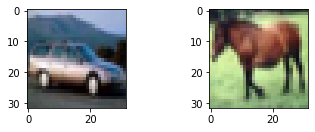

In [6]:
#https://stackoverflow.com/questions/41793931/plotting-images-side-by-side-using-matplotlib
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(X_train[4].reshape(32,32,3))
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(X_train[7].reshape(32,32,3))

### Augmenting Images

In [7]:
#https://keras.io/preprocessing/image/

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.5,
    brightness_range=[0.2,1.0])


datagen.fit(X_train)


Using TensorFlow backend.


### Defining blocks - (Dense, Transition and Output_layer)

In [0]:
# Dense Block
def denseblock(input, num_filter, dropout_rate):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same',kernel_initializer=he_normal())(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Block
def transition(input, num_filter, dropout_rate):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same',kernel_initializer=he_normal())(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    conv = layers.Conv2D(10,(1,1), use_bias=False, padding='same')(AvgPooling)
    last = layers.GlobalMaxPooling2D()(conv)
    output = layers.Activation('softmax')(last)
    return output

### Model

In [0]:
# Hyperparameters
batch_size = 64
num_classes = 10
epochs = 150
l = 8
compression = 1
dropout_rate = 0.2

In [10]:
input = layers.Input(shape=(img_height, img_width, channel))
First_Conv2D = layers.Conv2D(38, (3,3),strides=2, use_bias=False ,padding='same',activation='relu', kernel_initializer='he_uniform')(input)

First_Block = denseblock(First_Conv2D, 38, 0.2)
First_Transition = transition(First_Block, 38, 0.2)


Second_Block = denseblock(First_Transition, 38, 0.2)
Second_Transition = transition(Second_Block, 38, 0.2)


Third_Block = denseblock(Second_Transition, 38, 0.2)
Third_Transition = transition(Third_Block, 38, 0.2)


Last_Block = denseblock(Third_Transition, 38, 0.2)
output = output_layer(Last_Block)

model = Model(inputs=[input], outputs=[output])
model.summary()
tensorboard = TensorBoard(log_dir="logs/".format(time))

# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer = RMSprop(),
              metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 38)   1026        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 38)   152         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 38)   0           batch_normalization[0][0]        
_____________

In [12]:
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint

checkpointer = ModelCheckpoint(filepath="weights.h5", monitor='val_acc' ,verbose=1, save_best_only=True, mode='max')

model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs,verbose=1, 
                    validation_data=(X_test, y_test),callbacks=[checkpointer,tensorboard])

Epoch 1/150
10000/782 [===============================================================================================================================================================================================================================================================================================================================================================================================] - 4s 427us/sample - loss: 2.0264 - acc: 0.3680

Epoch 00001: val_acc improved from -inf to 0.36800, saving model to weights.h5
782/782 [==============================] - 92s 117ms/step - loss: 1.7869 - acc: 0.3463 - val_loss: 2.2817 - val_acc: 0.3680
Epoch 2/150
10000/782 [==============================================================================================================================================================================================================================================================================================================================

## Loading the saved model

In [0]:
model.load_weights("weights.h5")
model.compile(loss='categorical_crossentropy',
              optimizer = RMSprop(),
              metrics=['accuracy'])

### Evaluating model performance

In [14]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print("|","-"*50,"|")
print('  Test loss:', score[0])
print("|","-"*50,"|")
print('  Test accuracy:', score[1])
print("|","-"*50,"|")

10000/10000 [==============================] - 5s 477us/sample - loss: 0.3067 - acc: 0.9097
| -------------------------------------------------- |
  Test loss: 0.30672525559067726
| -------------------------------------------------- |
  Test accuracy: 0.9097
| -------------------------------------------------- |


### Visulaizing model

In [4]:
"""%load_ext tensorboard
%tensorboard --logdir logs"""

'%load_ext tensorboard\n%tensorboard --logdir logs'

<img src="model.png">